# playing around with a network
https://grand.networkmedicine.org/cell/Lung_Cancer/
cellline HCC827

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import variation
from networkx.algorithms import approximation as approx
import powerlaw
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def create_directed_graph(adj):
    """
    Create a directed graph from an adjacency matrix.
    """
    edges = adj.stack().reset_index()
    edges.columns = ['source', 'target', 'weight']
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges.values)
    del adj
    return G


In [ ]:
import time

def get_experiment_score(gene_list):
    return target_counts.loc[target_counts.index.intersection(gene_list), 'count'].sum()


def get_experiment_statistics(node_list, n_edges):
    score_dict = {
        "genes": len(node_list),
        "edges": n_edges,
        "target_genes": {
            "landmark": 0,
            "best_inferred": 0,
            "inferred": 0
        },
        "experiments": {
            "landmark": 0,
            "best_inferred": 0,
            "inferred": 0
        }
    }

    for feature in ["landmark", "best inferred", "inferred"]:
        relevant_genes = set(node_list) & set(target_counts[target_counts['feature_space'] == feature].index)
        key = feature.replace(" ", "_")
        score_dict["target_genes"][key] = len(relevant_genes)
        score_dict["experiments"][key] = get_experiment_score(relevant_genes)

    return score_dict

def get_structure_statistics(G):
    stats = {}

    # Separate degree types for directed graphs
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    total_degrees = [d for n, d in G.degree()]

    if len(total_degrees) == 0:
        return {
            "avg_in_degree": 0,
            "avg_out_degree": 0,
            "in_degree_var": 0,
            "out_degree_var": 0,
            "gini_in": 0,
            "gini_out": 0,
            "clustering": 0,
            "avg_path_length": 0,
            "powerlaw_alpha": 0,
        }

    # Directed degree statistics
    stats["avg_in_degree"] = np.mean(in_degrees)
    stats["avg_out_degree"] = np.mean(out_degrees)
    stats["in_degree_var"] = np.var(in_degrees)
    stats["out_degree_var"] = np.var(out_degrees)

    # Measure time for gini coefficient
    start_time = time.time()
    stats["gini_in"] = gini_coefficient(in_degrees)
    stats["gini_out"] = gini_coefficient(out_degrees)
    print(f"Gini coefficient calculation took {time.time() - start_time:.4f} seconds")

    # Use undirected version for clustering and path length
    G_undirected = G.to_undirected()

    # Measure time for clustering coefficient
    start_time = time.time()
    stats["clustering"] = nx.average_clustering(G_undirected)
    print(f"Clustering coefficient calculation took {time.time() - start_time:.4f} seconds")

    # Measure time for average shortest path length
    start_time = time.time()
    try:
        stats["avg_path_length"] = nx.average_shortest_path_length(G_undirected)
    except nx.NetworkXError:
        stats["avg_path_length"] = None
    print(f"Average shortest path length calculation took {time.time() - start_time:.4f} seconds")

    # Measure time for power law fit
    if len(total_degrees) >= 50:
        start_time = time.time()
        fit = powerlaw.Fit(total_degrees, verbose=False)
        stats["powerlaw_alpha"] = round(fit.power_law.alpha, 2)
        print(f"Power-law fit calculation took {time.time() - start_time:.4f} seconds")
    else:
        stats["powerlaw_alpha"] = None

    return stats


def gini_coefficient(array):
    start_time = time.time()
    array = np.array(array)
    if np.amin(array) < 0:
        array -= np.amin(array)  # shift to non-negative
    array = np.sort(array)
    n = len(array)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)
    result = ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))
    print(f"Gini coefficient computation took {time.time() - start_time:.4f} seconds")
    return result

In [ ]:
def print_statistics(score_dict):
    print("==========================")
    print(f"Total number of nodes: {score_dict['genes']}")
    print(f"Total number of edges: {score_dict['edges']}")
    
    print("\n--- Target Genes ---")
    for k, v in score_dict["target_genes"].items():
        print(f"{k.replace('_', ' ').title()}: {v}")

    print("\n--- Experiment Scores ---")
    for k, v in score_dict["experiments"].items():
        print(f"{k.replace('_', ' ').title()}: {v}")

    print("\n--- Structural Properties ---")
    props = {
        "Avg in degree": score_dict["avg_in_degree"],
        "Avg out degree": score_dict["avg_out_degree"],
        "In degree variance": score_dict["in_degree_var"],
        "Out degree variance": score_dict["out_degree_var"],
        "Gini coefficient (in degree)": score_dict["gini_in"],
        "Gini coefficient (out degree)": score_dict["gini_out"],
        "Avg clustering coefficient": score_dict["clustering"],
        "Avg path length": score_dict["avg_path_length"],
        "Power-law alpha (scale-free)": score_dict["powerlaw_alpha"],
    }
    for k, v in props.items():
        print(f"{k}: {round(v, 3) if isinstance(v, (float, int)) and v is not None else v}")


In [ ]:
def filter_edges_by_threshold(G: nx.DiGraph, threshold):
    # Remove edges with weight less than the threshold
    edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w['weight'] < threshold]
    G.remove_edges_from(edges_to_remove)
    
    # Get the largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    
    # Remove nodes that are not part of the largest weakly connected component
    G.remove_nodes_from(set(G.nodes) - largest_cc)
    
    return G



In [ ]:
def collect_statistics(thresholds, G, print_output=False):
    statistics_list = []

    for threshold in tqdm(thresholds):
        print(f"\n=== Filter with threshold: {threshold} ===")
        G_filtered = filter_edges_by_threshold(G, threshold)
        node_list = list(G_filtered.nodes())
        print("--- calculating experiment statistics ---")
        experiment_statistics = get_experiment_statistics(node_list, G_filtered.number_of_edges())

        # Add network structure statistics
        print("--- calculating structure statistics ---")
        structure_stats = get_structure_statistics(G_filtered)
        experiment_statistics.update(structure_stats)

        statistics_list.append(experiment_statistics)
        if print_output:
            print("--- printing statistics ---")
            print_statistics(experiment_statistics)

    return statistics_list

In [ ]:
def plot_general_statistics(statistics_list, thresholds, name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 7))
    fig.suptitle(f'Graph Statistics by Threshold - {name}', fontsize=22)

    # --- Plot 1: Number of Nodes ---
    axs[0].plot(thresholds, [s["genes"] for s in statistics_list], marker='o')
    axs[0].set_title('Total Number of Nodes', fontsize=14)
    axs[0].set_xlabel('Threshold')
    axs[0].set_ylabel('Nodes')
    axs[0].grid(True)

    # --- Plot 2: Number of Edges ---
    axs[1].plot(thresholds, [s["edges"] for s in statistics_list], marker='o', color='darkblue')
    axs[1].set_title('Total Number of Edges', fontsize=14)
    axs[1].set_xlabel('Threshold')
    axs[1].set_ylabel('Edges')
    axs[1].grid(True)
    
    # Finalize
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(name + '_general.png', dpi=300)
    plt.show()

In [ ]:
def plot_experiment_statistics(statistics_list, thresholds, name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 7))
    fig.suptitle(f'Graph Statistics by Threshold - {name}', fontsize=22)

    # --- Plot 1: Target Genes ---
    axs[0].plot(thresholds, [s["target_genes"]["landmark"] for s in statistics_list], marker='o', label='Landmark')
    axs[0].plot(thresholds, [s["target_genes"]["best_inferred"] for s in statistics_list], marker='o', label='Best Inferred')
    axs[0].plot(thresholds, [s["target_genes"]["inferred"] for s in statistics_list], marker='o', label='Inferred')
    axs[0].plot(thresholds, [
        s["target_genes"]["landmark"] + s["target_genes"]["best_inferred"] + s["target_genes"]["inferred"]
        for s in statistics_list], marker='o', linestyle='--', label='Total')
    axs[0].set_title('Target Genes by Feature Space', fontsize=14)
    axs[0].set_xlabel('Threshold')
    axs[0].set_ylabel('Number of Target Genes')
    axs[0].legend()
    axs[0].grid(True)

    # --- Plot 2: Experiment Score ---
    axs[1].plot(thresholds, [s["experiments"]["landmark"] for s in statistics_list], marker='o', label='Landmark')
    axs[1].plot(thresholds, [s["experiments"]["best_inferred"] for s in statistics_list], marker='o', label='Best Inferred')
    axs[1].plot(thresholds, [s["experiments"]["inferred"] for s in statistics_list], marker='o', label='Inferred')
    axs[1].plot(thresholds, [
        s["experiments"]["landmark"] + s["experiments"]["best_inferred"] + s["experiments"]["inferred"]
        for s in statistics_list], marker='o', linestyle='--', label='Total')
    axs[1].set_title('Total Experiment Score', fontsize=14)
    axs[1].set_xlabel('Threshold')
    axs[1].set_ylabel('Experiment Score')
    axs[1].legend()
    axs[1].grid(True)

        # Finalize
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(name + '_experiment.png', dpi=300)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_statistics_list(statistics_list, thresholds, name):
    # Create a grid of 3x2 subplots
    fig, axs = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Graph & Experiment Statistics by Threshold', fontsize=22)

    # --- Plot 1: Number of Nodes ---
    axs[0, 0].plot(thresholds, [s["genes"] for s in statistics_list], marker='o')
    axs[0, 0].set_title('Total Number of Nodes', fontsize=14)
    axs[0, 0].set_xlabel('Threshold')
    axs[0, 0].set_ylabel('Nodes')
    axs[0, 0].grid(True)

    # --- Plot 2: Number of Edges ---
    axs[0, 1].plot(thresholds, [s["edges"] for s in statistics_list], marker='o', color='darkblue')
    axs[0, 1].set_title('Total Number of Edges', fontsize=14)
    axs[0, 1].set_xlabel('Threshold')
    axs[0, 1].set_ylabel('Edges')
    axs[0, 1].grid(True)

    # --- Plot 3: Target Genes ---
    axs[1, 0].plot(thresholds, [s["target_genes"]["landmark"] for s in statistics_list], marker='o', label='Landmark')
    axs[1, 0].plot(thresholds, [s["target_genes"]["best_inferred"] for s in statistics_list], marker='o', label='Best Inferred')
    axs[1, 0].plot(thresholds, [s["target_genes"]["inferred"] for s in statistics_list], marker='o', label='Inferred')
    axs[1, 0].plot(thresholds, [
        s["target_genes"]["landmark"] + s["target_genes"]["best_inferred"] + s["target_genes"]["inferred"]
        for s in statistics_list], marker='o', linestyle='--', label='Total')
    axs[1, 0].set_title('Target Genes by Feature Space', fontsize=14)
    axs[1, 0].set_xlabel('Threshold')
    axs[1, 0].set_ylabel('Number of Target Genes')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # --- Plot 4: Experiment Score ---
    axs[1, 1].plot(thresholds, [s["experiments"]["landmark"] for s in statistics_list], marker='o', label='Landmark')
    axs[1, 1].plot(thresholds, [s["experiments"]["best_inferred"] for s in statistics_list], marker='o', label='Best Inferred')
    axs[1, 1].plot(thresholds, [s["experiments"]["inferred"] for s in statistics_list], marker='o', label='Inferred')
    axs[1, 1].plot(thresholds, [
        s["experiments"]["landmark"] + s["experiments"]["best_inferred"] + s["experiments"]["inferred"]
        for s in statistics_list], marker='o', linestyle='--', label='Total')
    axs[1, 1].set_title('Total Experiment Score', fontsize=14)
    axs[1, 1].set_xlabel('Threshold')
    axs[1, 1].set_ylabel('Experiment Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # # --- Plot 5: Clustering Coefficient & Path Length ---
    # axs[2, 0].plot(thresholds, [s["clustering"] for s in statistics_list], marker='o', label='Clustering Coeff.')
    # avg_paths = [s["avg_path_length"] if s["avg_path_length"] is not None else float('nan') for s in statistics_list]
    # axs[2, 0].plot(thresholds, avg_paths, marker='o', label='Avg Path Length')
    # axs[2, 0].set_title('Small-World Properties', fontsize=14)
    # axs[2, 0].set_xlabel('Threshold')
    # axs[2, 0].set_ylabel('Value')
    # axs[2, 0].legend()
    # axs[2, 0].grid(True)

    # --- Plot 6: Gini & Power-Law Alpha ---
    axs[2, 1].plot(thresholds, [s["gini_in"] for s in statistics_list], marker='o', label='Gini In-Degree')
    axs[2, 1].plot(thresholds, [s["gini_out"] for s in statistics_list], marker='o', label='Gini Out-Degree')
    alphas = [s["powerlaw_alpha"] if s["powerlaw_alpha"] is not None else float('nan') for s in statistics_list]
    axs[2, 1].plot(thresholds, alphas, marker='o', label='Power-law Alpha')
    axs[2, 1].set_title('Scale-Free Indicators', fontsize=14)
    axs[2, 1].set_xlabel('Threshold')
    axs[2, 1].set_ylim(0, 4)
    axs[2, 1].set_ylabel('Value')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # Finalize
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(name + '.png', dpi=300)
    plt.show()


In [ ]:
# load the adjacency matrix
adj = pd.DataFrame(pd.read_csv('../data/A549.csv', index_col='Row'))

In [ ]:
# load the target counts
target_counts = pd.read_csv('../data/target_counts.csv', index_col='gene_symbol')

In [ ]:
# create the directed graph
G = create_directed_graph(adj)

In [ ]:
# create a graph G_landmark that removes all nodes that are not listed in landmark_genes.txt
landmark_genes = pd.read_csv('../data/landmark_genes.txt', header=None)
landmark_genes = landmark_genes[0].tolist()
G_landmark = G.subgraph(landmark_genes).copy()
print(f"Number of nodes in landmark graph: {G_landmark.number_of_nodes()}")
print(f"Number of edges in landmark graph: {G_landmark.number_of_edges()}")

In [ ]:
# print data
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
target_counts

In [ ]:
print("Min value: ", adj.values.flatten().min())
print("Max value: ", adj.values.flatten().max())
# plot a histogram of the edge weights but only between -20 and 20
plt.figure(figsize=(5, 4))
plt.xlim(-20, 20)
plt.grid()
plt.hist(adj.values.flatten(), bins=100)
plt.title('Histogram of Edge Weights')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')


In [ ]:
# Set thresholds for filtering edges
thresholds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
# Collect statistics for each threshold
statistics_list = collect_statistics(thresholds, G)

In [ ]:
plot_general_statistics(statistics_list, thresholds, 'total')

In [ ]:
plot_general_statistics(statistics_list_landmark, thresholds, 'landmark_graph')

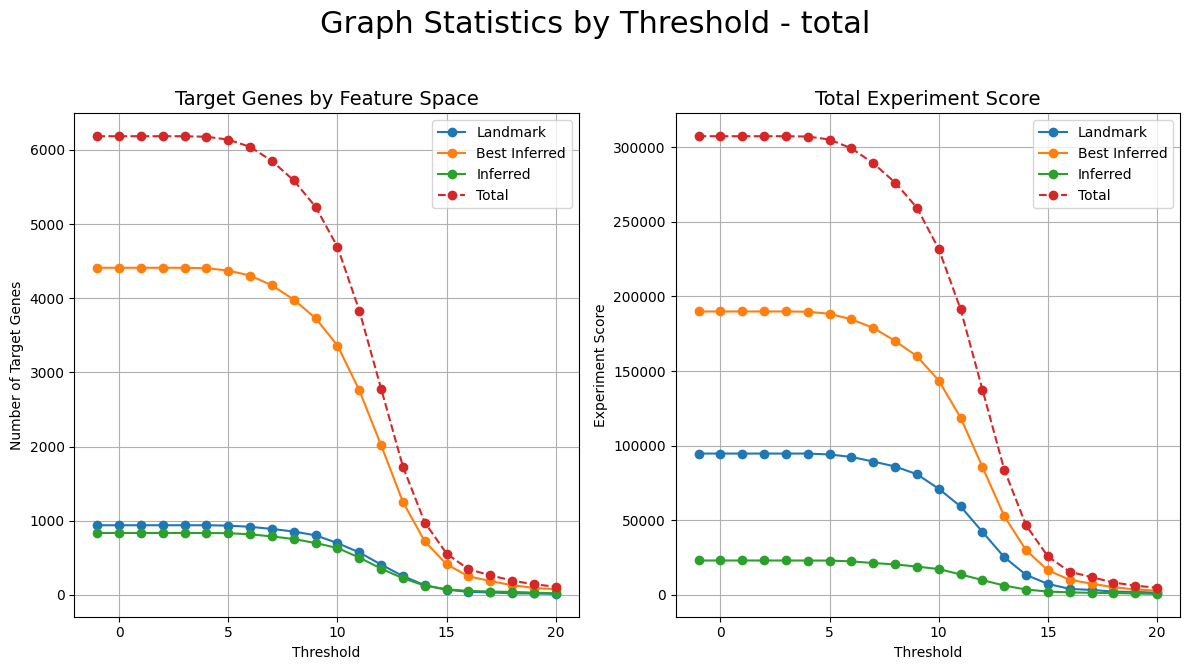

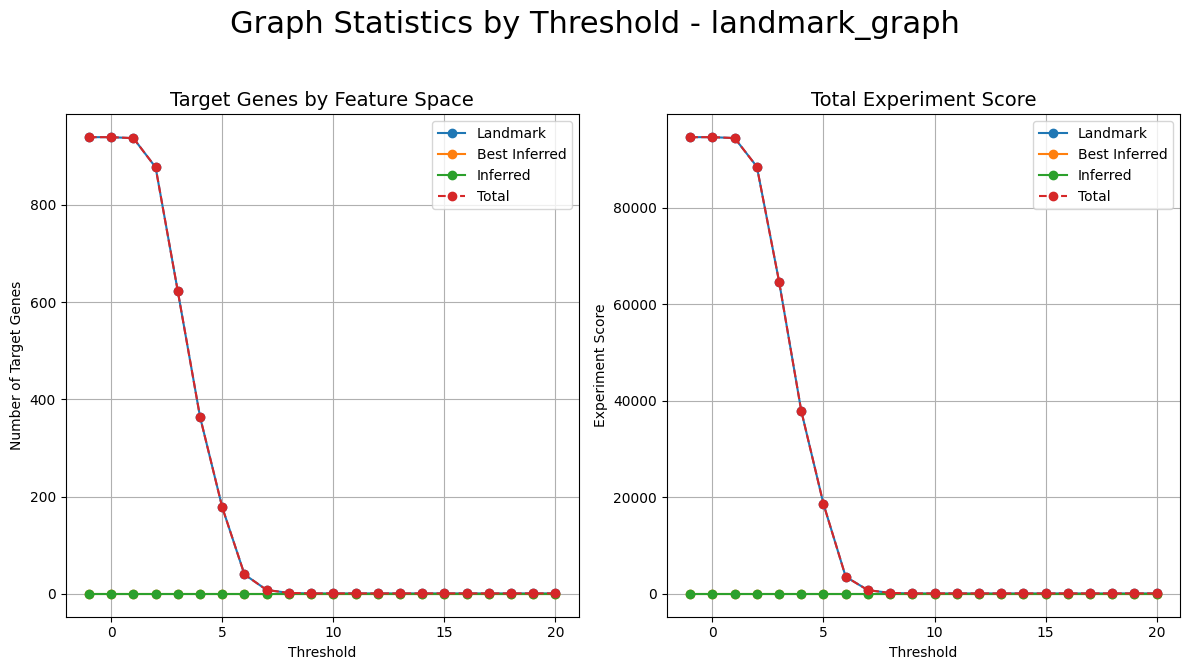

In [36]:
plot_experiment_statistics(statistics_list, thresholds, 'total')
plot_experiment_statistics(statistics_list_landmark, thresholds, 'landmark_graph')

In [ ]:
# Plot the statistics
plot_statistics_list(statistics_list, thresholds, 'A549')

In [ ]:
# Collect statistics for each threshold
statistics_list_landmark = collect_statistics(thresholds, G_landmark)

In [ ]:
# Plot the statistics
plot_statistics_list(statistics_list_landmark, thresholds, "landmark_graph")

## 📌 Interpretation Tips

### 🔹 Plot: Clustering Coefficient & Average Path Length
- **Use case**: Helps determine if the graph exhibits *small-world* properties.
- **Small-world networks** typically show:
  - **High clustering coefficient**: Nodes tend to cluster together.
  - **Short average path length**: Most nodes can be reached from every other by a small number of steps.
- **What to look for**:
  - Clustering coefficient remains relatively high, even as edges are filtered.
  - Average path length stays low or increases slowly.

---

### 🔹 Plot: Gini Coefficient & Power-law Alpha
- **Use case**: Helps determine if the graph is *scale-free*.
- **Scale-free networks** usually show:
  - **Highly skewed degree distribution** (few hubs with many connections).
  - Degree distribution follows a **power law**, i.e., `P(k) ~ k^(-α)`
- **What to look for**:
  - **Gini Coefficient**:
    - Values ≥ 0.6 suggest heavy-tailed distribution (strong inequality in node degrees).
    - Flat or increasing Gini as threshold increases may indicate robustness of hub structure.
  - **Power-law Alpha**:
    - Values between **2 and 3** typically indicate scale-free behavior.
    - If `alpha` is significantly higher, the tail is thinner (less hub dominance).

---

### 🔹 Plot: Number of Nodes & Edges
- **Use case**: Shows how dense or fragmented the graph becomes with increasing threshold.
- **What to look for**:
  - Sudden drops may indicate the breaking of the largest component or critical transitions.
  - Helps identify thresholds where the graph becomes disconnected or loses key structure.

---

### 🔹 Plot: Target Genes & Experiment Score
- **Use case**: Evaluates how biologically relevant the filtered graph remains.
- **What to look for**:
  - Whether important gene subsets (landmark, best inferred, inferred) remain represented.
  - Balance between maintaining experimental signal and filtering noise.
  - Compare the “Total” line with per-subset curves to track where signal is lost.

---

## 🧠 Summary

- A **small-world** graph has:  
  - High clustering  
  - Short average path length  
- A **scale-free** graph has:  
  - Skewed degree distribution  
  - High Gini coefficient  
  - Power-law alpha ~ 2–3  
- Balance statistical structure with biological relevance (target genes & experiment score).
